In [1]:
import numpy as np
import pandas as pd
from talib import abstract
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers 
from sklearn.metrics import mean_squared_error
import warnings
from tqdm.notebook import tqdm
from pypfopt import black_litterman, risk_models,BlackLittermanModel, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
warnings.filterwarnings('ignore')

In [2]:
價量天 = pd.read_pickle("價量天.pkl")  #111111111111111
價量周 = pd.read_pickle("價量周.pkl")
財報季 = pd.read_pickle("財報季.pkl")
價量id = 價量天.id.unique()
財報id = 財報季.id.unique()

In [3]:
dff =財報季.copy()       #2222222222222222222
date_u=dff.date.unique()
dff.set_index(['date', 'id'], inplace=True)
dff = dff[~dff.index.duplicated(keep='first')]
date_final=[]
result_cond = np.array([])                     #530 831 1129 331 金控
final_pub = ["05-30","08-31","11-29","03-31"]  #5月15日、8月14日、11月14日、3月31日
j=0
for i in range(len(date_u)):
    now = pd.to_datetime(date_u[i],format='%Y-%m-%d')
    if j > 3 :
        j=0 
    if j == 3:
        date_cond = pd.to_datetime(f"{now.year+1}-{final_pub[j]}")
    else:
        date_cond = pd.to_datetime(f"{now.year}-{final_pub[j]}")
    cond = dff.loc[f"{now.strftime('%Y-%m-%d')}","publish"]<=date_cond
    threshold = 0.95
    if len(cond) < 20:
        threshold = 0.8
    k=1
    while sum(cond) <= len(cond)*threshold:
        date_cond = date_cond+pd.to_timedelta(k, unit='D')
        cond = (dff.loc[f"{now.strftime('%Y-%m-%d')}","publish"]<=date_cond).values
    j+=1
    result_cond =  np.append(result_cond,cond)
    date_final.append(date_cond)

print("是否完成標註日期",len(date_final)==len(date_u))
dff['result_cond'] = result_cond
dff['publish_fix'] = pd.Series()
for i in range(len(date_u)):
    now = pd.to_datetime(date_u[i],format='%Y-%m-%d').strftime('%Y-%m-%d')
    mon_count = len(dff.loc[now])
    unique_labels= dff.loc[now].index.get_level_values('id').unique()
    for j in range(mon_count):
        if dff.loc[(now,unique_labels[j]),"result_cond"] == 1:
            dff.loc[(now,unique_labels[j]),"publish_fix"] = date_final[i].strftime('%Y-%m-%d')
        elif dff.loc[(now,unique_labels[j]),"result_cond"] == 0:
            dff.loc[(now,unique_labels[j]),"publish_fix"] = None

是否完成標註日期 True


In [4]:
dff = dff.reset_index()       #333333333333333333
dff = dff[["date","publish_fix","id","流動負債","現金流量比率","流動比率","速動比率","負債比率","每股盈餘","營業收入淨額","稅前淨利","當季季底P/E","淨值週轉率（次）","存貨週轉率（次）"]]
dff = dff.sort_values(by=['date','id'])
dff.publish_fix = pd.to_datetime(dff["publish_fix"], errors='coerce')
刪除=dff[dff['流動負債'].isna()].id.unique()
dff = dff[~dff.id.isin(刪除)]
for column in dff.columns:
    if column != 'id' and column != 'date' and column != 'publish_fix':
        dff[column] = pd.to_numeric(dff[column], errors='coerce')
dff = dff.dropna(axis=0)
dff_id=dff.id.unique()

In [5]:
dff = dff.sort_values(by=['publish_fix'])
價量天 = 價量天[價量天.id.isin(dff_id)]
merged_data = pd.DataFrame() 
for i in dff_id:
    ff = pd.merge_asof(價量天.loc[價量天['id'] == i], dff.loc[dff['id'] == i], left_on="date", right_on="publish_fix", direction='backward')
    merged_data = pd.concat([merged_data,ff],axis=0) 
merged_data = merged_data[["date_x","id_x", '流動負債', '現金流量比率', '流動比率', '速動比率',
       '負債比率', '每股盈餘', '營業收入淨額', '稅前淨利', '當季季底P/E', '淨值週轉率（次）', '存貨週轉率（次）']]
merged_data.rename(columns={'date_x': 'date', 'id_x': 'id'}, inplace=True)
價量周 = 價量周[價量周.id.isin(dff_id)]
all_data = pd.merge(價量周, merged_data, on=['date','id'], how='left')
all_data = all_data.sort_values(by=['date','id'])

In [6]:
end_date = datetime.now().strftime("%Y-%m-%d")
大盤 = yf.download("^TWII", start='2008-01-01', end=end_date, interval='1d')
大盤.reset_index(inplace=True)
大盤 = 大盤[['Date','Close']]
大盤.columns = ['date','mkt_ret']
天_u = 價量天.date.unique()
大盤 = 大盤[大盤["date"].isin(天_u)]

[*********************100%%**********************]  1 of 1 completed


In [7]:
def LSTM_model():
    model = Sequential()

    model.add(LSTM(units=32, return_sequences=True, input_shape=X[0].shape))
    
    model.add(Dropout(0.2))

    model.add(LSTM(units=64, return_sequences=True))
    
    model.add(Dropout(0.2))

    model.add(Dense(units=1, activation='linear'))

    return model

In [8]:
all_data = all_data[(all_data.id!=1796)&(all_data.id!=8086)]
價量周 = 價量周[(價量周.id!=1796)&(價量周.id!=8086)]
價量天 = 價量天[(價量天.id!=8086)]
all_stock = all_data.id.unique()
all_data.drop_duplicates(subset=['date', 'id'], inplace=True)
價量周.drop_duplicates(subset=['date', 'id'], inplace=True)
價量天.drop_duplicates(subset=['date', 'id'], inplace=True)
df_day = 價量天.copy()
df_day.set_index(['date', 'id'], inplace=True)

In [9]:
outcomes = pd.DataFrame()
for stock_id in tqdm(all_stock):
    df_2330_day = df_day.loc[df_day.index.get_level_values('id') == stock_id]
    df_2330_day = df_2330_day.reset_index(level='id', drop=True)
    df_2330_day['return'] = df_2330_day['close'].pct_change()
    df_2330_day["vol"] = df_2330_day['return'].rolling(20).std()
    kd = abstract.STOCH(df_2330_day,fastk_period=15, slowk_period=8, slowd_period=8)
    rsi = abstract.RSI (df_2330_day, timeperiod=15)
    willr = abstract.WILLR(df_2330_day,timeperiod=14)
    obv = abstract.OBV(df_2330_day)
    atr = abstract.ATR(df_2330_day, timeperiod=14)
    cci = abstract.CCI(df_2330_day, timeperiod=20)
    mfi = abstract.MFI(df_2330_day, timeperiod=14)
    roc = abstract.ROC(df_2330_day, timeperiod=14)

    dataset = pd.DataFrame({
        'return_week': df_2330_day['return'].shift(5),
        'return_month': df_2330_day['return'].shift(22),
        'RSIb': rsi / 50,
        'KDb': kd["slowk"] - kd["slowd"],
        'a5':   (df_2330_day['close'].rolling(5).mean()   / df_2330_day['close']),
        'a10':  (df_2330_day['close'].rolling(10).mean()  / df_2330_day['close']),
        'obv': obv,
        'willr': willr,
        'atr': atr,
        'cci': cci,
        'mfi': mfi,
        'roc': roc,
        'vol': df_2330_day["vol"],
    })
    dataset = dataset.reset_index()
    dataset.rename(columns={'Date': 'date'}, inplace=True)
    df_2330 = all_data.loc[all_data['id'] == stock_id]
    df_2330_t = pd.merge(df_2330, 大盤,on=['date'], how='left')
    df_2330_t["mkt_ret"] = df_2330_t["mkt_ret"].pct_change()
    df_2330_week = pd.merge(df_2330_t, dataset,on=['date'], how='left')
    df_2330_week["pct"] = df_2330_week["close"].pct_change()
    df_2330_week["return"] = df_2330_week["pct"].shift(-1)
    df_2330_week.drop(columns=['id','pct'], inplace=True)
    df_2330_week.set_index('date', inplace=True)
    df_2330_week = df_2330_week.dropna()
    feature_names = list(df_2330_week.columns[:-1])
    ss = MinMaxScaler()
    dataset_scaled = ss.fit_transform(df_2330_week)
    dataset_scaled = pd.DataFrame(dataset_scaled, columns=df_2330_week.columns, index=df_2330_week.index)
    dataset_scaled['return'] = df_2330_week['return']
    n = 8
    X = []
    y = []
    indexes = []
    dataset_scaled_x = dataset_scaled[feature_names]

    for i in range(0, len(dataset_scaled)-n):
        X.append(dataset_scaled_x.iloc[i:i+n].values)
        y.append(dataset_scaled['return'].iloc[i+n-1])
        indexes.append(dataset_scaled.index[i+n-1])
    X = np.array(X)
    y = np.array(y)
    indexes = np.array(indexes)
    model = LSTM_model()
    adam = optimizers.Adam(lr=0.001)
    model.compile(optimizer=adam, loss='mean_squared_error')
    X_train = X[indexes < datetime(2019, 1, 1)]
    y_train = y[indexes < datetime(2019, 1, 1)]

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=100,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0)
    X_test = X[indexes >= datetime(2019, 1, 1)]
    y_ture = y[indexes >= datetime(2019, 1, 1)]
    y_pred = model.predict(X_test, verbose=0)
    indexes_test = indexes[indexes >= datetime(2019, 1, 1)]
    indexes_test = pd.to_datetime(indexes_test)
    yy = y_pred.swapaxes(0,1)[0].reshape(-1)
    aa = pd.DataFrame({"id":stock_id,"y_ture": y_ture,"y_pred":yy}, index=indexes_test)
    outcomes = pd.concat([outcomes,aa],axis=0)
    

  0%|          | 0/92 [00:00<?, ?it/s]

In [10]:
outcomes.reset_index(inplace=True)
outcomes.rename(columns={'index': 'date'}, inplace=True)
outcomes.sort_values(by=['date','id'], inplace=True)
id_92 = outcomes.id.unique()

In [11]:
outcomes_s = outcomes.groupby('date').apply(lambda x: 
                MinMaxScaler(feature_range=(-0.1, 0.1)).fit_transform(np.array(x['y_pred']).reshape(-1, 1)))

In [12]:
outcomes_date = outcomes.date.unique()
for  i in outcomes_date:
    outcomes.loc[outcomes.date==i,'y_pred_s'] = outcomes_s[outcomes_s.index == i][0].reshape(-1)

In [13]:
all_data_history = all_data[all_data.date >= '2016-01-01']
prices = all_data_history[["date","id","close"]]
prices = prices.pivot(index='date', columns='id', values='close')
date_uu = all_data.date.unique()
market_prices = yf.download("^TWII", start="2016-01-01",interval='1d')["Adj Close"]
market_prices = market_prices[market_prices.index.isin(date_uu)]

[*********************100%%**********************]  1 of 1 completed


In [14]:
市值_1 = 價量周[價量周["date"]>="2019-01-01"]
市值_1 = 市值_1[['date','id','caps','close']]
合併 = pd.merge(outcomes, 市值_1, on=['date','id'], how='left')
合併 = 合併.sort_values(by=['date','id'])

In [94]:
# data = {'累積報酬': [], 'CR': [],'sector_lower': [], 'sector_upper': []}
# max_sharpe = pd.DataFrame(data)
# sector_mapper = {2330: "tech"}
# for d in [0,0.05,0.1,0.15]:
#     for u in [0.7,0.75,0.8,0.9,1]:
#         sector_lower = {"tech": d}  
#         sector_upper = {"tech": u}
#         empty_multi_index = pd.MultiIndex.from_arrays([[], []], names=['Date', 'id'])
#         all_weights = pd.DataFrame(index=empty_multi_index)
#         合併_u = 合併.date.unique()
#         for i in 合併_u:
#             invest_d = 合併[合併["date"]==i]
#             invest_s = invest_d.id.unique()
#             market = market_prices[market_prices.index < i]
#             pp = prices[prices.columns[prices.columns.isin(invest_s)]]
#             pp = pp[pp.index < i]
#             mcaps = {}
#             for t in invest_s:
#                 mcaps[t] = invest_d[invest_d.id == t]["caps"].values[0]
#             viewdict = {}
#             for t in invest_s:
#                 viewdict[t] = invest_d[invest_d.id == t]["y_pred_s"].values[0]
#             confidences = [0.5] * len(invest_s)
#             S = risk_models.CovarianceShrinkage(pp).ledoit_wolf()
#             delta = black_litterman.market_implied_risk_aversion(market, risk_free_rate=0.01)
#             market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S,risk_free_rate=0.01)
#             bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)
#             ret_bl = bl.bl_returns()
#             ef = EfficientFrontier(ret_bl, S)
#             ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
#             ef.max_sharpe(risk_free_rate=0.01)
#             weights = ef.clean_weights()
#             a = pd.Series(weights)
#             a = a[a.values != 0]
#             for z in range(len(a)):
#                 all_weights.loc[(i, a.index[z]), 'Weight'] = a.values[z]
#         all_weights.reset_index(inplace=True)
#         all_data["ret"] = all_data.groupby("id")["close"].pct_change()
#         all_data["ret"] = all_data.groupby("id")["ret"].shift(-1)
#         porfolio_ret = np.array([])
#         for i in 合併_u:
#             qq = all_weights[all_weights.Date == i]
#             rett = 0
#             for m in range(len(qq)):
#                 sig = all_data[(all_data.date == qq.Date.iloc[m]) & (all_data.id == qq.id.iloc[m])]["ret"].values[0]
#                 sig_ret = sig * qq.Weight.iloc[m]
#                 rett += sig_ret
#             porfolio_ret = np.append(porfolio_ret,rett)
#         初始資金 = 1000
#         累積報酬 = np.cumprod(1+porfolio_ret)-1
#         年化報酬 = np.power(累積報酬[-1]+1, 1/(1792/365))-1
#         標準差 = np.std(porfolio_ret)
#         年化標準差 = 標準差*np.sqrt(52)
#         資金曲線 = 初始資金 * (1 + 累積報酬)
#         risk_free_rate = 0.01  
#         sharpe = (年化報酬 - risk_free_rate) / 年化標準差
#         drawdown_percent = (資金曲線/np.maximum.accumulate(資金曲線)) - 1
#         mdd = abs(drawdown_percent.min())
#         Calmar_Ratio = 年化報酬 / mdd
#         max_sharpe.loc[len(max_sharpe)] = [累積報酬[-1], Calmar_Ratio,d, u]

In [95]:
# max_sharpe.sort_values(by=['累積報酬','CR'], inplace=True, ascending=False)
#max_sharpe.head(5)

,累積報酬,CR,sector_lower,sector_upper
0,1.109653,0.479723,0.00,0.70
5,1.109653,0.479723,0.05,0.70
10,1.109653,0.479723,0.10,0.70
15,1.109653,0.479723,0.15,0.70
6,1.100104,0.462360,0.05,0.75


In [15]:
# BL
sector_mapper = {2330: "tech"}
sector_lower = {"tech": 0}  
sector_upper = {"tech": 0.7}
empty_multi_index = pd.MultiIndex.from_arrays([[], []], names=['Date', 'id'])
all_weights = pd.DataFrame(index=empty_multi_index)
合併_u = 合併.date.unique()
for i in 合併_u:
    invest_d = 合併[合併["date"]==i]
    invest_s = invest_d.id.unique()
    market = market_prices[market_prices.index < i]
    pp = prices[prices.columns[prices.columns.isin(invest_s)]]
    pp = pp[pp.index < i]
    mcaps = {}
    for t in invest_s:
        mcaps[t] = invest_d[invest_d.id == t]["caps"].values[0]
    viewdict = {}
    for t in invest_s:
        viewdict[t] = invest_d[invest_d.id == t]["y_pred_s"].values[0]
    confidences = [0.1] * len(invest_s)
    S = risk_models.CovarianceShrinkage(pp).ledoit_wolf()
    delta = black_litterman.market_implied_risk_aversion(market, risk_free_rate=0.01)
    market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S,risk_free_rate=0.01)
    bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)
    ret_bl = bl.bl_returns()
    ef = EfficientFrontier(ret_bl, S)
    #ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
    ef.max_sharpe(risk_free_rate=0.01)
    weights = ef.clean_weights()
    a = pd.Series(weights)
    a = a[a.values != 0]
    for z in range(len(a)):
        all_weights.loc[(i, a.index[z]), 'Weight'] = a.values[z]
all_weights.reset_index(inplace=True)

In [25]:
all_weights.groupby('Date').apply(lambda x: x.sort_values(by='Weight', ascending=False).head(2))[["id","Weight"]]

id   Weight
Date                          
2019-01-04 25    2330  0.38191
           46    6505  0.06807
2019-01-11 73    2330  0.39267
           94    6505  0.06892
2019-01-18 111   2330  0.39219
...               ...      ...
2023-11-17 6183  2454  0.05451
2023-11-24 6190  2330  0.85707
           6191  2454  0.06039
2023-12-01 6198  2330  0.86025
           6199  2454  0.05989

[508 rows x 2 columns]

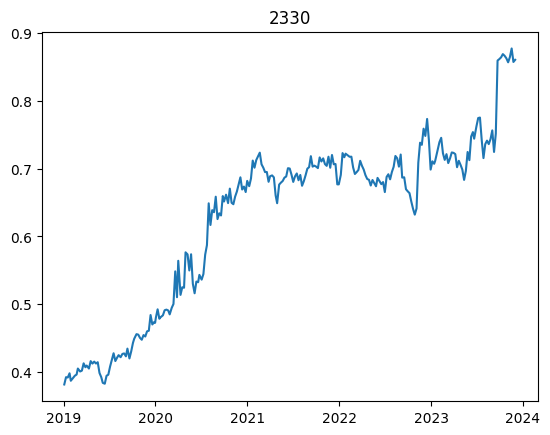

In [20]:
yy = all_weights[all_weights.id == 2330]["Weight"]
xx = all_weights[all_weights.id == 2330]["Date"]
plt.plot(xx,yy)
plt.title("2330")
plt.show()

In [60]:
# MV
empty_multi_index = pd.MultiIndex.from_arrays([[], []], names=['Date', 'id'])
all_weights = pd.DataFrame(index=empty_multi_index)
合併_u = 合併.date.unique()
for i in 合併_u:
    invest_d = 合併[合併["date"]==i]
    invest_s = invest_d.id.unique()
    pp = prices[prices.columns[prices.columns.isin(invest_s)]]
    pp = pp[pp.index < i]
    S = risk_models.CovarianceShrinkage(pp,frequency=52).ledoit_wolf()
    exp_r = expected_returns.mean_historical_return(pp, frequency=52)
    ef = EfficientFrontier(exp_r, S)
    #ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
    ef.max_sharpe(risk_free_rate=0.01)
    weights = ef.clean_weights()
    a = pd.Series(weights)
    a = a[a.values != 0]
    for z in range(len(a)):
        all_weights.loc[(i, a.index[z]), 'Weight'] = a.values[z]
all_weights.reset_index(inplace=True)

In [58]:
all_data["ret"] = all_data.groupby("id")["close"].pct_change()
all_data["ret"] = all_data.groupby("id")["ret"].shift(-1)

In [118]:
# BL
porfolio_ret = np.array([])
for i in 合併_u:
    qq = all_weights[all_weights.Date == i]
    rett = 0
    for m in range(len(qq)):
        sig = all_data[(all_data.date == qq.Date.iloc[m]) & (all_data.id == qq.id.iloc[m])]["ret"].values[0]
        sig_ret = sig * qq.Weight.iloc[m]
        rett += sig_ret
    porfolio_ret = np.append(porfolio_ret,rett)
print(len(porfolio_ret))
bl_porfolio_ret = porfolio_ret

254


In [61]:
#  MV
porfolio_ret = np.array([])
for i in 合併_u:
    qq = all_weights[all_weights.Date == i]
    rett = 0
    for m in range(len(qq)):
        sig = all_data[(all_data.date == qq.Date.iloc[m]) & (all_data.id == qq.id.iloc[m])]["ret"].values[0]
        sig_ret = sig * qq.Weight.iloc[m]
        rett += sig_ret
    porfolio_ret = np.append(porfolio_ret,rett)
print(len(porfolio_ret))
mv_porfolio_ret = porfolio_ret

254


In [62]:
#等權重
porfolio_ret = np.array([])
for i in 合併_u:
    qq = all_data[all_data.date == i]
    qq.dropna(inplace=True)
    len_id = qq.id.unique()
    w = 1/len(len_id)
    rett = 0
    for j in len_id:
        sig = qq[qq.id == j]["ret"].values[0]
        sig_ret = sig * w
        rett += sig_ret
    porfolio_ret = np.append(porfolio_ret,rett)
print(len(porfolio_ret))
等權重 = porfolio_ret

254


In [63]:
#市值加權
porfolio_ret = np.array([])
for i in 合併_u:
    qq = all_data[all_data.date == i]
    qq.dropna(inplace=True)
    len_id = qq.id.unique()
    total_caps = qq.caps.sum()
    rett = 0
    for j in len_id:
        sig = qq[qq.id == j]["ret"].values[0]
        w = qq[qq.id == j]["caps"].values[0]/total_caps
        sig_ret = sig * w
        rett += sig_ret
    porfolio_ret = np.append(porfolio_ret,rett)
print(len(porfolio_ret))
市值加權 = porfolio_ret

254


In [66]:
元大50 = yf.download("0050.TW", start="2019-01-01",end="2023-12-02",interval='1d')["Adj Close"]
元大50_2 = yf.download("0050.TW", start="2023-12-08",end="2023-12-09")["Adj Close"]
元大50 = 元大50[元大50.index.isin(合併_u)]
元大50 = pd.concat([元大50,元大50_2],axis=0)
元大50 = 元大50.pct_change().dropna()
inv_time = 元大50.index[-1] - 元大50.index[0]
inv_time

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


Timedelta('1792 days 00:00:00')

In [119]:
# BL
初始資金 = 1000
累積報酬 = np.cumprod(1+bl_porfolio_ret)-1
年化報酬 = np.power(累積報酬[-1]+1, 1/(1792/365))-1
標準差 = np.std(bl_porfolio_ret)
年化標準差 = 標準差*np.sqrt(52)
資金曲線 = 初始資金 * (1 + 累積報酬)
print(f"累積報酬：{累積報酬[-1]}")
print(f"年化報酬：{年化報酬}")
risk_free_rate = 0.01  
sharpe = (年化報酬 - risk_free_rate) / 年化標準差
print(f"夏普率：{sharpe}")
drawdown_percent = (資金曲線/np.maximum.accumulate(資金曲線)) - 1
mdd = abs(drawdown_percent.min())
print(f"最大回撤：{mdd}")
Calmar_Ratio = 年化報酬 / mdd
print(f"Calmar Ratio：{Calmar_Ratio}")

累積報酬：0.9345631255664717
年化報酬：0.1438579005604257
夏普率：0.6687567652120513
最大回撤：0.3606063892959922
Calmar Ratio：0.39893331019807454


In [68]:
# 0050
初始資金 = 1000
累積報酬 = np.cumprod(1+元大50.values)-1
年化報酬 = np.power(累積報酬[-1]+1, 1/(1792/365))-1
標準差 = np.std(元大50.values)
年化標準差 = 標準差*np.sqrt(52)
資金曲線 = 初始資金 * (1 + 累積報酬)
print(f"累積報酬：{累積報酬[-1]}")
print(f"年化報酬：{年化報酬}")
risk_free_rate = 0.01  
sharpe = (年化報酬 - risk_free_rate) / 年化標準差
print(f"夏普率：{sharpe}")

# 計算最大回撤
drawdown_percent = (資金曲線/np.maximum.accumulate(資金曲線)) - 1
mdd = abs(drawdown_percent.min())
print(f"最大回撤：{mdd}")
Calmar_Ratio = 年化報酬 / mdd
print(f"Calmar Ratio：{Calmar_Ratio}")

累積報酬：1.1359404005367142
年化報酬：0.1671635455209035
夏普率：0.8737691897330078
最大回撤：0.3340678259657952
Calmar Ratio：0.5003880425707897


In [69]:
#等權重
初始資金 = 1000
累積報酬 = np.cumprod(1+等權重)-1
年化報酬 = np.power(累積報酬[-1]+1, 1/(1792/365))-1
標準差 = np.std(等權重)
年化標準差 = 標準差*np.sqrt(52)
資金曲線 = 初始資金 * (1 + 累積報酬)
print(f"累積報酬：{累積報酬[-1]}")
print(f"年化報酬：{年化報酬}")
risk_free_rate = 0.01  
sharpe = (年化報酬 - risk_free_rate) / 年化標準差
print(f"夏普率：{sharpe}")

drawdown_percent = (資金曲線/np.maximum.accumulate(資金曲線)) - 1
mdd = abs(drawdown_percent.min())
print(f"最大回撤：{mdd}")
Calmar_Ratio = 年化報酬 / mdd
print(f"Calmar Ratio：{Calmar_Ratio}")

累積報酬：1.4323934227968191
年化報酬：0.1984737893115942
夏普率：1.187197074882606
最大回撤：0.24257015452362207
Calmar Ratio：0.8182119094633563


In [70]:
#市值加權
初始資金 = 1000
累積報酬 = np.cumprod(1+市值加權)-1
年化報酬 = np.power(累積報酬[-1]+1, 1/(1792/365))-1
標準差 = np.std(市值加權)
年化標準差 = 標準差*np.sqrt(52)
資金曲線 = 初始資金 * (1 + 累積報酬)
print(f"累積報酬：{累積報酬[-1]}")
print(f"年化報酬：{年化報酬}")
risk_free_rate = 0.01  
sharpe = (年化報酬 - risk_free_rate) / 年化標準差
print(f"夏普率：{sharpe}")

drawdown_percent = (資金曲線/np.maximum.accumulate(資金曲線)) - 1
mdd = abs(drawdown_percent.min())
print(f"最大回撤：{mdd}")
Calmar_Ratio = 年化報酬 / mdd
print(f"Calmar Ratio：{Calmar_Ratio}")

累積報酬：1.0575065746582966
年化報酬：0.1583032990112796
夏普率：0.7962863912582029
最大回撤：0.3238114552555956
Calmar Ratio：0.4888749191603654


In [71]:
# MV
初始資金 = 1000
累積報酬 = np.cumprod(1+mv_porfolio_ret)-1
年化報酬 = np.power(累積報酬[-1]+1, 1/(1792/365))-1
標準差 = np.std(mv_porfolio_ret)
年化標準差 = 標準差*np.sqrt(52)
資金曲線 = 初始資金 * (1 + 累積報酬)
print(f"累積報酬：{累積報酬[-1]}")
print(f"年化報酬：{年化報酬}")
risk_free_rate = 0.01  
sharpe = (年化報酬 - risk_free_rate) / 年化標準差
print(f"夏普率：{sharpe}")

drawdown_percent = (資金曲線/np.maximum.accumulate(資金曲線)) - 1
mdd = abs(drawdown_percent.min())
print(f"最大回撤：{mdd}")
Calmar_Ratio = 年化報酬 / mdd
print(f"Calmar Ratio：{Calmar_Ratio}")

累積報酬：1.4020895041051062
年化報酬：0.19541736621641248
夏普率：0.8601681395920173
最大回撤：0.3245431376671235
Calmar Ratio：0.6021306369966991


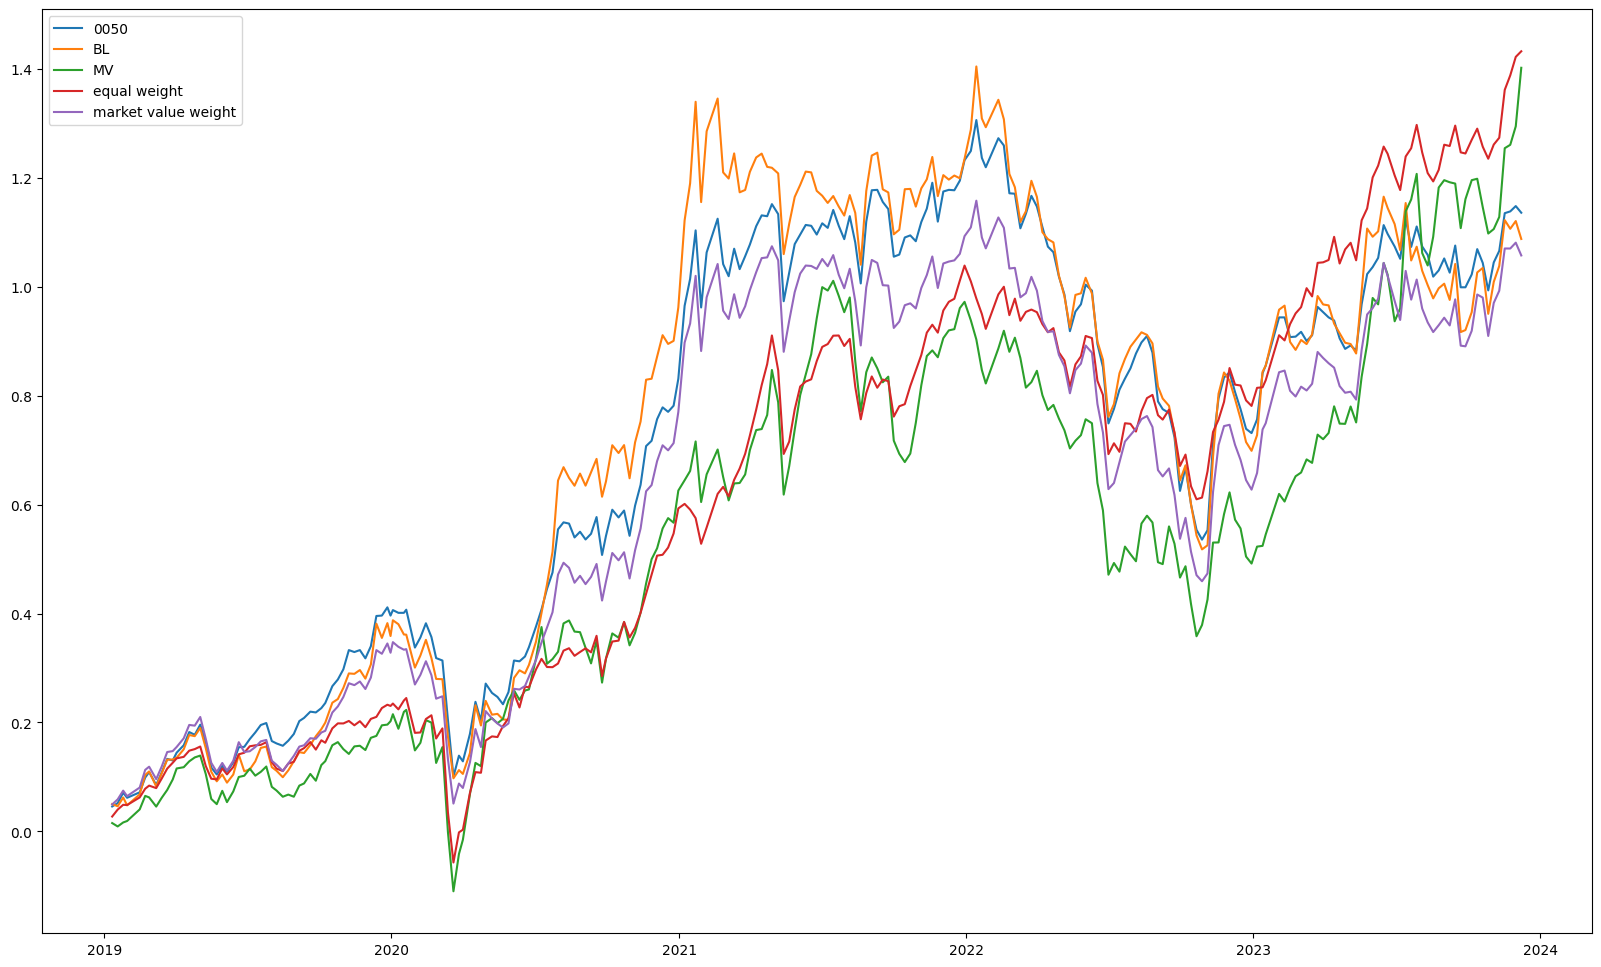

In [111]:
plt.figure(figsize=(20, 12))
plt.plot(元大50.index,np.cumprod(1+元大50.values)-1, label="0050")
plt.plot(元大50.index,np.cumprod(1+bl_porfolio_ret)-1, label="BL")
plt.plot(元大50.index,np.cumprod(1+mv_porfolio_ret)-1, label="MV")
plt.plot(元大50.index,np.cumprod(1+等權重)-1, label="equal weight")
plt.plot(元大50.index,np.cumprod(1+市值加權)-1, label="market value weight")
plt.legend()
plt.show()

In [120]:
bl_1 = bl_porfolio_ret.copy()

In [116]:
bl_9 = bl_porfolio_ret.copy()

In [112]:
bl_5 = bl_porfolio_ret.copy()

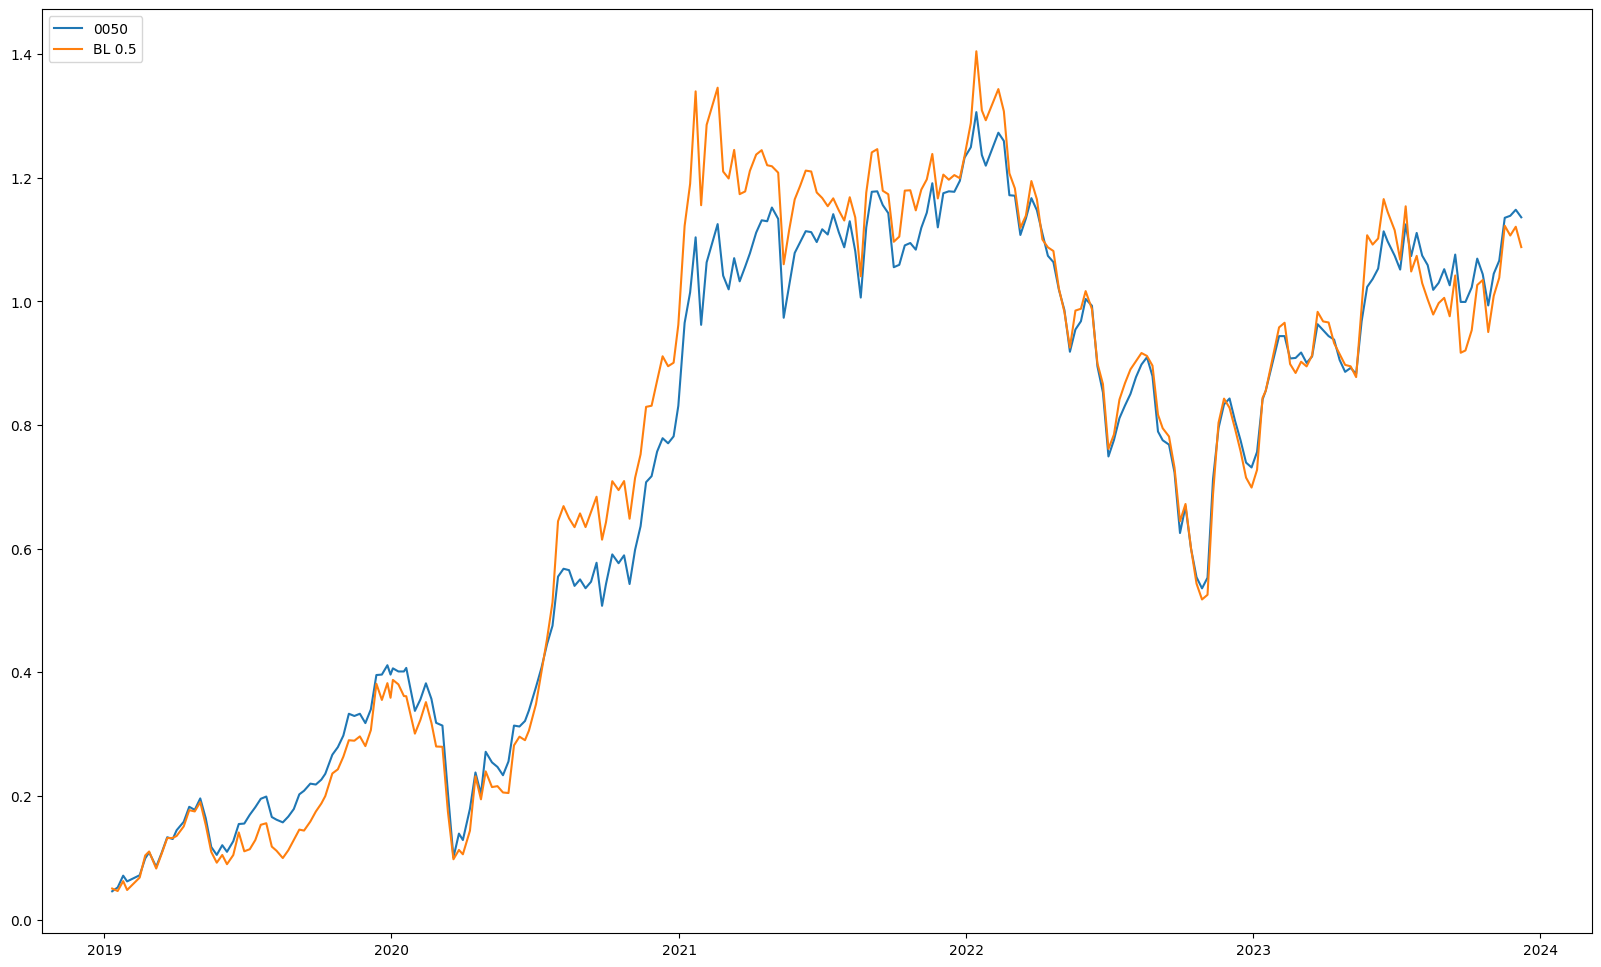

In [123]:
plt.figure(figsize=(20, 12))
plt.plot(元大50.index,np.cumprod(1+元大50.values)-1, label="0050")
plt.plot(元大50.index,np.cumprod(1+bl_5)-1, label="BL 0.5")
plt.legend(loc='upper left')
plt.show()

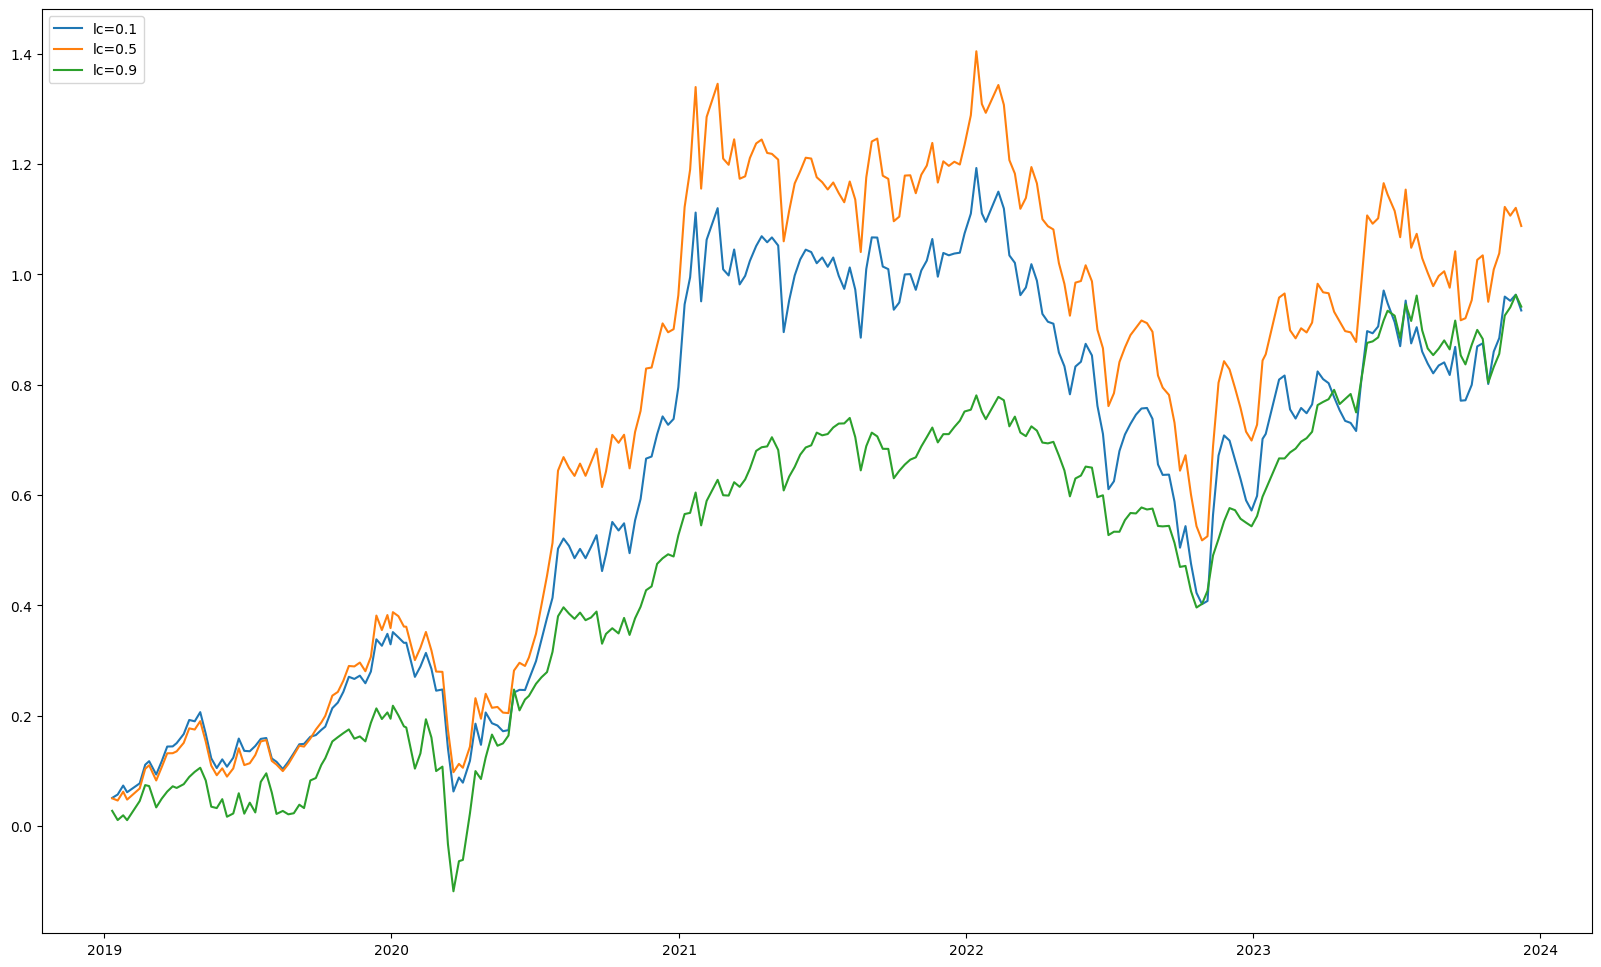

In [122]:
plt.figure(figsize=(20, 12))
plt.plot(元大50.index,np.cumprod(1+bl_1)-1, label="lc=0.1")
plt.plot(元大50.index,np.cumprod(1+bl_5)-1, label="lc=0.5")
plt.plot(元大50.index,np.cumprod(1+bl_9)-1, label="lc=0.9")
plt.legend(loc='upper left')
plt.show()

In [146]:
covid_19_S = 元大50.index[62]
covid_19_E = 元大50.index[200]
covid_19 = 元大50.loc[covid_19_S:covid_19_E]
bl_covid_19 = bl_5[62:201]
delta = covid_19.index[-1] - covid_19.index[0]
delta = delta.days


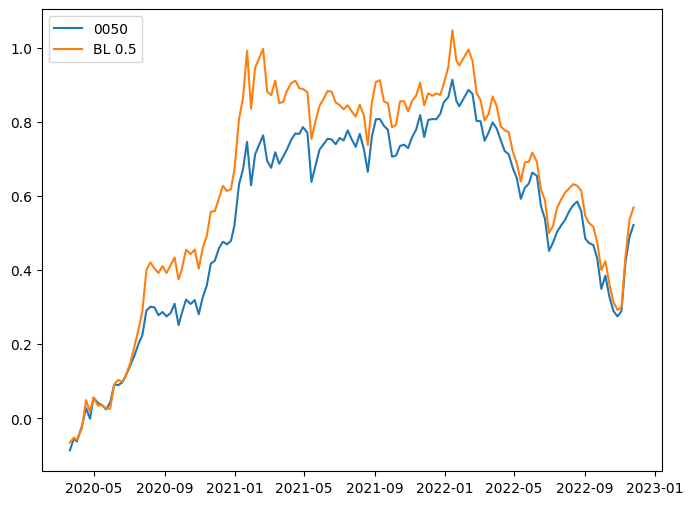

In [144]:
plt.figure(figsize=(8, 6))
plt.plot(covid_19.index,np.cumprod(1+covid_19.values)-1, label="0050")
plt.plot(covid_19.index,np.cumprod(1+bl_covid_19)-1, label="BL 0.5")
plt.legend(loc='upper left')
plt.show()

In [147]:
初始資金 = 1000
累積報酬 = np.cumprod(1+covid_19)-1
年化報酬 = np.power(累積報酬[-1]+1, 1/(delta/365))-1
標準差 = np.std(covid_19)
年化標準差 = 標準差*np.sqrt(52)
資金曲線 = 初始資金 * (1 + 累積報酬)
print(f"累積報酬：{累積報酬[-1]}")
print(f"年化報酬：{年化報酬}")
risk_free_rate = 0.01  
sharpe = (年化報酬 - risk_free_rate) / 年化標準差
print(f"夏普率：{sharpe}")

drawdown_percent = (資金曲線/np.maximum.accumulate(資金曲線)) - 1
mdd = abs(drawdown_percent.min())
print(f"最大回撤：{mdd}")
Calmar_Ratio = 年化報酬 / mdd
print(f"Calmar Ratio：{Calmar_Ratio}")

累積報酬：0.5222089865479309
年化報酬：0.1693980355948086
夏普率：0.7779524623898069
最大回撤：0.3340678259657953
Calmar Ratio：0.507076774319934


In [148]:
初始資金 = 1000
累積報酬 = np.cumprod(1+bl_covid_19)-1
年化報酬 = np.power(累積報酬[-1]+1, 1/(delta/365))-1
標準差 = np.std(bl_covid_19)
年化標準差 = 標準差*np.sqrt(52)
資金曲線 = 初始資金 * (1 + 累積報酬)
print(f"累積報酬：{累積報酬[-1]}")
print(f"年化報酬：{年化報酬}")
risk_free_rate = 0.01  
sharpe = (年化報酬 - risk_free_rate) / 年化標準差
print(f"夏普率：{sharpe}")

drawdown_percent = (資金曲線/np.maximum.accumulate(資金曲線)) - 1
mdd = abs(drawdown_percent.min())
print(f"最大回撤：{mdd}")
Calmar_Ratio = 年化報酬 / mdd
print(f"Calmar Ratio：{Calmar_Ratio}")

累積報酬：0.5694256632326307
年化報酬：0.1827785573199332
夏普率：0.7626798736301903
最大回撤：0.3687874269123733
Calmar Ratio：0.4956203600817518


In [5]:
a = pd.read_csv("6446TWO.csv")
a["ret"] = a["Adj Close"].pct_change()
a.dropna(inplace=True)
std_a = np.std(a["ret"])
std_a*np.sqrt(252)

0.47828405066720453